In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import matplotlib as plt
import seaborn as sns
from random import randint, choice
from os import path
from main_data import (
    key_to_camelot,
    add_features,
    get_playlist,
    get_friendly,
    json_to_df,
    add_features,
    sp,
)


In [2]:
# Import DataFrames generated by main_data.py
def import_all():
    (
        all_streams,
        music_streams_no_features,
        music_streams,
        no_skip_df,
        playlist_example,
        podcasts,
        wheel_df,
    ) = json_to_df(
        "all_streams.json",
        "music_streams_no_features.json",
        "music_streams.json",
        "no_skip_df.json",
        "playlist_example.json",
        "podcasts.json",
        "wheel_df.json",
    )
    return all_streams, music_streams_no_features, music_streams, no_skip_df, playlist_example, podcasts, wheel_df

# todo: move to main

def hpm(df, average=None):
    # df["month"] = df.copy().timestamp.dt.month
    df_groupby = df.sort_values(by="month").groupby(["month", pd.Grouper(key='timestamp', freq='Y')])['playtime_h'].sum().groupby("month")
    return df_groupby.mean().sort_index() if average else df_groupby.sum().sort_index()

def plothpm(df_gb):
    df_gb.index = pd.PeriodIndex(df_gb.index, freq="M")
    df_gb = df_gb.sort_index()
    df_gb.index = df_gb.index.strftime("%b")
    # df_gb.index = df_gb.rename(lambda x: x.strftime("%b"))
    return sns.barplot(data=df_gb.iloc[0:0], x=df_gb.index, y=df_gb.values)

def del_skips(deef):
    return deef.query("(playtime_s / duration) > 0.75").reset_index()

def most_played(df, years=False, noskips=False, artists=False, nofeatures=False):
    cols = ["artist", "track", "year"]
    if noskips:
        df = del_skips(df) 
    if not years:
        years = df.timestamp.dt.year.unique()
        cols.remove("year")
    if artists:
        cols.remove("track")
    return pd.DataFrame(df.query("timestamp.dt.year in @years").pivot_table(columns=cols, aggfunc="size").sort_values(ascending=False)).reset_index().rename(columns={0: "count"})

def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)

def randyear(df):
    return choice(range(df.timestamp.dt.year.min(), 
                        df.timestamp.dt.year.max() +1))

In [3]:
all_streams, music_streams_no_features, music_streams, no_skip_df, playlist_example, podcasts, wheel_df = import_all()

In [4]:
most_played(podcasts.drop_duplicates(subset='track'), artists=True).head(5)

,artist,count
0,Behind the Bastards,429
1,The Bechdel Cast,196
2,Citations Needed,149
3,Trillbilly Worker's Party,145
4,You're Wrong About,115


In [5]:
streams_by_month_mean = plothpm(hpm(all_streams, average=True))
plt.pyplot.gcf().set_size_inches(3, 2)
plt.pyplot.savefig('streams_by_month_mean.jpg', dpi=500)
plt.pyplot.close()
streams_by_month_sum = plothpm(hpm(all_streams))
plt.pyplot.savefig('streams_by_month_sum.jpg', dpi=500)
plt.pyplot.close()

**Mean:** ![](streams_by_month_mean.jpg) **Sum:** ![](streams_by_month_sum.jpg)

<AxesSubplot: xlabel='month'>

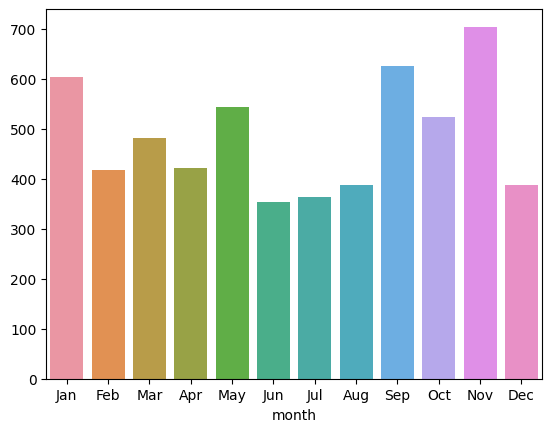

In [6]:
plothpm(hpm(all_streams))

In [7]:

music_streams# I don't recall listening to this artist so much. Investigating if it was on repeat on accident or something.
why_tala = music_streams_no_features#.query('"Hope Tala" in artist')
why_why_tala = (
    why_tala.loc[:, ['playtime_s', 'timestamp']].groupby(by=why_tala.timestamp.dt.hour)
    .sum(numeric_only=True)
    .sort_values(by="playtime_s", ascending=False))
why_why_tala["playtime_s"] = why_why_tala["playtime_s"].apply(lambda x: x / 3600)
why_why_tala.head(50)


,playtime_s
timestamp,
5,217.660833
6,213.599722
7,200.713056
4,195.744722
9,177.740278
3,176.846111
2,174.491389
8,172.493056
10,161.819167


In [8]:
# Looks like I just let her run on most popular song repeat for a few hours.
music_streams_no_features.query('date == "11/27/2019"').sort_values(by="timestamp")


,timestamp,playtime_s,track,artist,album,id,shuffle,playtime_m,playtime_h,date,month,year,day
78510,2019-11-27 05:00:06,162,Blue,Hope Tala,Blue,2jNdYJVaPnG3I4XJApXnZy,False,2.70,0.05,2019-11-27,Nov,2019,Wed
54104,2019-11-27 05:03:07,181,Valentine,Hope Tala,Starry Ache,4JoDBcODOajOx3ZRQlSa7o,False,3.02,0.05,2019-11-27,Nov,2019,Wed
42212,2019-11-27 05:06:13,185,Sunburn,Hope Tala,Sensitive Soul,5jjTld8YpUHmBbr4SDYmo8,False,3.08,0.05,2019-11-27,Nov,2019,Wed
83689,2019-11-27 05:08:18,122,Summer in Paris (Interlude),Hope Tala,Starry Ache,2XsYOvhSLUWgCTM10aZ4CV,False,2.03,0.03,2019-11-27,Nov,2019,Wed
60470,2019-11-27 05:11:51,213,Eden,Hope Tala,Starry Ache,6ryhckbki35oQU9AS01JWI,False,3.55,0.06,2019-11-27,Nov,2019,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10584,2019-11-27 22:22:51,207,This Life,Denzel Curry,Imperial,2aQwdBWk4vSPWk1Csgtzdo,False,3.45,0.06,2019-11-27,Nov,2019,Wed
44184,2019-11-27 22:26:54,243,Zenith,Denzel Curry,Imperial,67T0J1IDGgRwNMp3vWYaVb,False,4.05,0.07,2019-11-27,Nov,2019,Wed
84067,2019-11-27 22:30:50,236,Good Night,Denzel Curry,Imperial,6bcnokzOVQxpn0quzHj6vc,False,3.93,0.07,2019-11-27,Nov,2019,Wed
35559,2019-11-28 01:32:49,87,If Tomorrow's Not Here,Denzel Curry,Imperial,3oy9CClx1zCGnhzse9AvDu,False,1.45,0.02,2019-11-27,Nov,2019,Wed


In [9]:
no_skip_df.query('artist.str.contains("(?i)miles davis")', engine="python")


,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.50,2019-09-30,Mon,Sep,2019,119,9B,G major,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11,450,0.12
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.48,2022-05-28,Sat,May,2022,119,9B,G major,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59,449,0.12
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.50,2021-09-05,Sun,Sep,2021,119,9B,G major,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02,450,0.12
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.50,2021-05-28,Fri,May,2021,119,9B,G major,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10,450,0.12
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.50,2021-07-16,Fri,Jul,2021,119,9B,G major,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49,450,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47412,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),199,3.32,2022-02-20,Sun,Feb,2022,106,4A,F minor,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35,199,0.06
47558,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),220,3.67,2019-11-24,Sun,Nov,2019,122,3B,D-flat major,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15,220,0.06
47593,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),435,7.25,2022-02-21,Mon,Feb,2022,134,8B,C major,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48,435,0.12
47602,Miles Davis,"So Near, So Far",Seven Steps To Heaven,417,6.95,2020-01-24,Fri,Jan,2020,84,9B,G major,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07,417,0.12


In [10]:
music_streams

,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
0,Rich Boy,Throw Some D's Remix,Rich Boy,351,5.85,2021-03-25,Thu,Mar,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26,351,0.10
1,Rich Boy,Throw Some D's Remix,Rich Boy,351,2.60,2021-08-07,Sat,Aug,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-08-07 05:06:29,156,0.04
2,Rich Boy,Throw Some D's Remix,Rich Boy,351,5.85,2021-01-21,Thu,Jan,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09,351,0.10
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,0.00,2019-10-18,Fri,Oct,2019,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2019-10-18 18:04:48,0,0.00
4,Rich Boy,Throw Some D's Remix,Rich Boy,351,0.03,2022-02-17,Thu,Feb,2022,161,12A,D-flat minor,True,1qXLj4ywjsA0hGmaibmnn3,2022-02-17 11:15:58,2,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85407,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236,3.93,2022-09-29,Thu,Sep,2022,100,6B,B-flat major,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58,236,0.07
85408,Teitanblood,Anteinfierno,Death,297,4.95,2021-09-24,Fri,Sep,2021,101,6A,G minor,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37,297,0.08
85409,Xenia Rubinos,How Strange It Is,Black Terry Cat,192,3.20,2019-12-05,Thu,Dec,2019,112,11B,A major,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04,192,0.05
85410,Master P,Meal Ticket,I'm Bout It,244,4.07,2021-01-18,Mon,Jan,2021,152,10B,D major,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48,244,0.07


In [11]:
music_streams.sort_values(by="playtime_s")

,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
47809,Ludwig van Beethoven,"Piano Sonata No. 11 In B Flat Major, Op. 22: 4...",Beethoven: The Piano Sonatas,371,0.00,2020-04-04,Sat,Apr,2020,131,6B,B-flat major,False,4W1CenpP9ZxvSwhRHkgVF6,2020-04-04 14:15:08,0,0.00
3782,Main Source,Just a Friendly Game of Baseball - 2017 Remast...,Breaking Atoms,202,0.00,2021-05-07,Fri,May,2021,94,11A,F-sharp minor,False,3gI4WHUyXCP96IQb9hzxnJ,2021-05-07 14:13:54,0,0.00
16421,Aphex Twin,Nanou2,Drukqs,205,0.00,2020-01-04,Sat,Jan,2020,93,4B,A-flat major,False,6Wei2NUSG66WzLiqSuQAy5,2020-01-04 05:15:09,0,0.00
82851,Sasha Carassi,Nomads,Kill The Monster EP,416,0.00,2022-04-15,Fri,Apr,2022,122,12A,D-flat minor,False,6z8CNKl6hK2yAvqnUXZeoU,2022-04-15 10:01:06,0,0.00
69678,Y1640,Spit Intent,Spit Intent,259,0.00,2020-04-04,Sat,Apr,2020,150,8B,C major,False,0id4Rkg8xaN68PKcIHCfAp,2020-04-04 17:47:22,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82774,William Basinski,El Camino Real,El Camino Real,3000,50.00,2021-01-28,Thu,Jan,2021,142,3B,D-flat major,False,5owloXCqdMDgyXfLXrdpAc,2021-01-28 12:50:11,3000,0.83
64071,William Basinski,dlp 5,The Disintegration Loops III,3141,52.35,2021-02-02,Tue,Feb,2021,135,7B,F major,False,36XtPJCvIs7ucoMDMIBRI7,2021-02-02 08:55:46,3141,0.87
67998,William Basinski,dlp 1.1,The Disintegration Loops,3816,63.60,2022-07-26,Tue,Jul,2022,95,7B,F major,False,10SeyQmuBIVJmbZYYJs07W,2022-07-26 10:01:01,3816,1.06
70705,William Basinski,dlp 1.1,The Disintegration Loops,3816,63.60,2021-01-28,Thu,Jan,2021,95,7B,F major,False,31FiS1jMI38kYfC8ey358W,2021-01-28 09:30:35,3816,1.06


In [12]:
top_songs(music_streams_no_features, skips=True).head(30)


NameError: name 'top_songs' is not defined

In [ ]:
pivot_track = pd.DataFrame(
    no_skip_df.query('year == 2022')
    .pivot_table(columns=["artist", "track", "year"], aggfunc="size")
    .sort_values(ascending=False))

pivot_track.head(30)


In [ ]:
no_skip_df.query('year == 2022')


In [ ]:
# # Check for tracks missing from new df
# series1 = duration_prep['spotify_track_uri']
# series2 = local_features['uri']
# comparison = series1[~series1.isin(series2)]
# comparison


In [ ]:
# # Show missing track URLs for further investigation; track is likely removed or yet to be analyzed for audio_features.
# missing_tracks = []
# for i in range(len(comparison)):
#     missing_tracks.append(sp.track(comparison.iloc[i])['external_urls'])
# missing_tracks


In [ ]:
# Most played tracks
pivot_track = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist", "track"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_track


In [ ]:
# Most listened to artists by number of songs played
pivot_artist = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_artist


In [ ]:
miles = no_skip_df.query('artist.str.contains("(?i)Miles Davis")')
pivot_miles = pd.pivot_table(miles, values="playtime_s", index=["album"], aggfunc="sum")
pivot_miles = pivot_miles.sort_values(by="playtime_s", ascending=False)
miles


In [ ]:
pivot_album_time = pd.pivot_table(
    no_skip_df, values="playtime_s", index=["album"], aggfunc="sum"
)


In [ ]:
pivot_album_time = pivot_album_time.sort_values(by="playtime_s", ascending=False)
pivot_album_time.head(20)


In [ ]:
pivot_artist_time = pd.pivot_table(
    no_skip_df, values="playtime_h", index=["artist"], aggfunc="sum"
)


In [ ]:
# print(pivot_artist_time.sort_values().to_string())
artist_time = pivot_artist_time.sort_values(
    by="playtime_h", ascending=False
).reset_index()
print(artist_time.to_string())


In [ ]:
# Artists played more than 10 mins
repeated_artists = artist_time[:1750]
# Number of unique tracks played from those artists

len(music_streams["track"].unique())


In [ ]:
still_repeated = repeated_artists["artist"]


In [ ]:
# Count number of unique tracks per artist and create ascending list
still_still_repeated = no_skip_df.query("artist in @still_repeated")
# still_still_repeated.loc[:, 'artist'] = still_still_repeated.copy().loc[:, 'artist'].astype(str)
group = still_still_repeated.groupby("artist")
songs_per_artist = group.apply(lambda x: x["track"].unique())
unique_songs = songs_per_artist.reset_index(name="unique_titles")


In [ ]:
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()


In [ ]:
unique_songs = unique_songs.sort_values(by="unique_count").reset_index()


In [ ]:
unique_export = unique_songs.query("unique_count <= 8")["artist"]


In [ ]:
pivot_artist_time.playtime_h


In [ ]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should seek more songs from, and/or artists with very long average song lengths.
pivot_artist_time.query("playtime_h > 1").query("artist in @unique_export").sort_values(by="playtime_h", ascending=False).head(50)


In [ ]:
# Show longest songs
no_skip_df.sort_values(by="playtime_s", axis=0, ascending=False)


In [ ]:
music_streams.query('year == 2019')

In [ ]:
# How to control this for missing months? do october 25 2019 thru 2022
plt.rcParams['figure.figsize']=(8,8)
sns_prep = music_streams.query('year == 2019| year == 2020 | year == 2021')
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime_s",
    index=sns_prep.timestamp.dt.strftime("%b"),
    aggfunc="sum",
).reset_index()
sns_prep["playtime_h"] = sns_prep["playtime_s"].apply(lambda x: x / 3600000)
sns.barplot(data=sns_prep, x=sns_prep.index, y="playtime_h")


In [ ]:
# sum of unique uris closely maps to total skips per month
sns_prep = music_streams.copy().drop_duplicates(subset="id")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# good way to find months with most music discovery along with unique URIs
sns_prep = music_streams.copy().query("(playtime_s / duration) < 0.25")
sns_prep.at[:, "count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# common keys of listened tracks
no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"]
pivot_track = pd.DataFrame(
    no_skip_df.drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


In [ ]:
# # This version works with uri
# #should also have function to get uri from song title + artist
# #todo: proper type hinting and default values
# # separate functions i suppose, maybe with decorators
# # https://stackoverflow.com/questions/62153371/best-way-to-create-python-function-with-multiple-options


get_friendly(
    music_streams, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shift=["all"]
).sort_values(by="track")


In [ ]:
# How often do I play songs with "birthday" in the name on my loved ones' birthdays?
music_streams.query("(playtime_s / duration) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


<AxesSubplot: xlabel='month'>

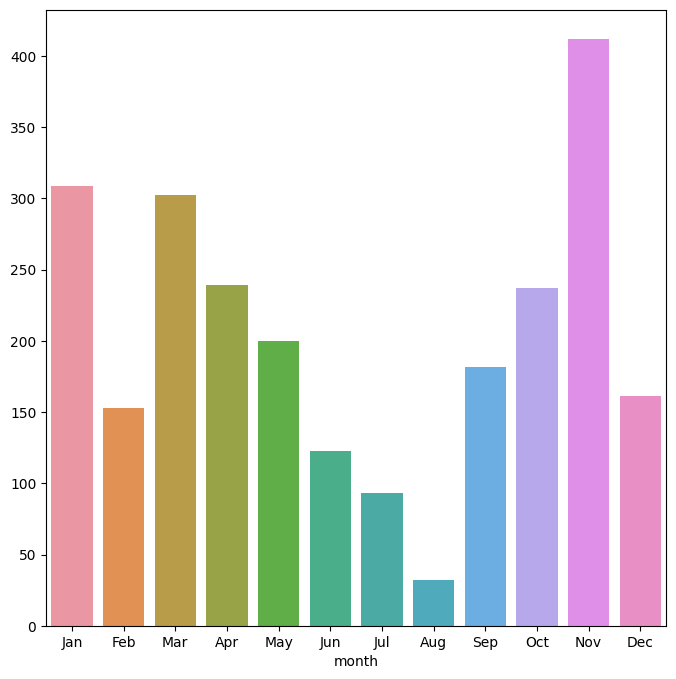

In [ ]:
plothpm(hpm(podcasts))


In [ ]:
plothpm(hpm(top_songs(music_streams))

KeyError: 'month'

In [ ]:
# Todo: plot podcast listening vs music listening
# damn i really spent most of january 2022 listening to podcats

plothpm(hpm(no_skip_df))